<a href="https://colab.research.google.com/github/omarhashem80/titantic-task1/blob/main/Titantic_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic-data-for-data-preprocessing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1680488%2F2754327%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T045551Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d197e377479e03dcd464b5d180b59e9b1eeb7955a9ab245f15d880ae7cd5c1d80ed5734fd524960108849a982fb23bfb353f7edb5ad457d1b2bae0edab72c856fe436816476b751a009d58aaf9868af191e6140ef06985f005d12d19130e217fafae48e0c12722046ca5e832325d45e620cc7304cf409041f3c053f92b1e4fad24b7426a021a55fade7937a869b516c1eda85048ebd492bae409081ebc175b5f1022f836e4902968c562290fa6b92853526557bfe84b952302bf4a83b15bb5311b47f0e6d78c973e6a374769f8c34ab9471d0691dc1c90c60871edadd693f6f59f464e139b0e533e3aeb2cf51e7cec4b9799148f4e9873ea5251c16926ba334'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7463 bytes downloaded
Downloaded and uncompressed: titanic-data-for-data-preprocessing
Data source import complete.


## 🔴Import Libraries 📦

In [3]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.2 MB/s eta 0:00:00


In [4]:
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, kruskal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

## 🔴Load Dataset 🗂️

In [5]:
df = pd.read_csv("/kaggle/input/titanic-data-for-data-preprocessing/titanic_data.csv")
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
885,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
886,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
887,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## 🔴Features Understanding 📖

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    object 
 3   age          713 non-null    float64
 4   sibsp        889 non-null    int64  
 5   parch        889 non-null    int64  
 6   fare         889 non-null    float64
 7   embarked     887 non-null    object 
 8   class        889 non-null    object 
 9   who          889 non-null    object 
 10  adult_male   889 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  887 non-null    object 
 13  alive        889 non-null    object 
 14  alone        889 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.2+ KB


In [7]:
cats = df.select_dtypes("O").columns.to_list()

In [8]:
for cat in cats:
    print(df[cat].value_counts())
    print("*"*50)

sex
male      575
female    314
Name: count, dtype: int64
**************************************************
embarked
S    643
C    168
Q     76
Name: count, dtype: int64
**************************************************
class
Third     489
First     216
Second    184
Name: count, dtype: int64
**************************************************
who
man      535
woman    271
child     83
Name: count, dtype: int64
**************************************************
deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64
**************************************************
embark_town
Southampton    643
Cherbourg      168
Queenstown      76
Name: count, dtype: int64
**************************************************
alive
no     547
yes    342
Name: count, dtype: int64
**************************************************


1. **survived**: This column indicates whether the passenger survived (1) or not (0).
2. **pclass**: This column represents the ticket class of the passenger (1 = 1st, 2 = 2nd, 3 = 3rd).
3. **sex**: This column indicates the gender of the passenger.
4. **age**: This column represents the age of the passenger.
5. **sibsp**: This column indicates the number of siblings/spouses aboard the Titanic.
6. **parch**: This column indicates the number of parents/children aboard the Titanic.
7. **fare**: This column represents the fare paid by the passenger.
8. **embarked**: This column indicates the port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).
9. **class**: This column represents the passenger class (similar to 'pclass', but with a different representation).
10. **who**: This column indicates whether the passenger is a man, woman, or child.
11. **adult_male**: This column indicates if the passenger is an adult male (True/False).
12. **deck**: This column indicates the deck where the passenger's cabin was located.
13. **embark_town**: This column represents the town where the passenger embarked.
14. **alive**: This column indicates whether the passenger survived (yes) or not (no).
15. **alone**: This column indicates whether the passenger was traveling alone (True/False).

## 🔴Cleaning🕵️

In [9]:
df.isna().mean()*100

survived        0.000000
pclass          0.000000
sex             0.000000
age            19.797525
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.224972
class           0.000000
who             0.000000
adult_male      0.000000
deck           77.165354
embark_town     0.224972
alive           0.000000
alone           0.000000
dtype: float64

In [10]:
# Removing 'deck' due to its high NaN percentage (77%); the other columns being dropped have equivalent meanings' columns
df.drop(['deck', 'survived', 'pclass', 'embarked'], axis=1, inplace=True)

### 🔴Drop Duplicates

In [11]:
df.duplicated().sum()

111

In [12]:
df.drop_duplicates(inplace=True)

## 🔴EDA

In [13]:
cats = df.select_dtypes("O").columns.to_list()
len(cats)

5

### 🔴Univariante Analysis **👆**



#### 🟢Numerical🔢

In [14]:
nums = ['age', 'fare']

In [15]:
def create_histogram_with_boxplot(d, x):
    """
    Create a Plotly figure containing a histogram and a box plot for a specified column in a DataFrame.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x (str): The name of the column to plot.

    Returns:
    - fig (go.Figure): Plotly figure containing the histogram and box plot.
    """
    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Histogram(x=df[x], name='Histogram'), row=1, col=1)
    fig.add_trace(go.Box(x=df[x], name="Box"), row=2, col=1)
    fig.update_layout(
        title=f'Distribution of {x}',
        height=600,
    )
    return fig

In [16]:
df[nums].describe()

,age,fare
count,675.000000,778.000000
mean,29.812474,34.898532
std,14.738018,52.312674
min,0.420000,0.000000
25%,20.000000,8.050000
50%,28.000000,16.050000
75%,39.000000,34.375000
max,80.000000,512.329200


In [17]:
i = 0
create_histogram_with_boxplot(df,nums[i])

In [18]:
i = 1
create_histogram_with_boxplot(df,nums[i])

#### 🔵Categorical

In [19]:
def create_pie_chart(df, cat):
    """
    Create a Plotly pie chart for the distribution of categories in a specified column of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - cat (str): The name of the categorical column to plot.

    Returns:
    - fig (px.pie): Plotly pie chart.
    """
    fig = px.pie(names=df[cat], hole=0.3, title=f"Distribution of {cat}")
    fig.update_traces(textinfo='percent+label')
    fig.update_layout(height=800)  # Adjust height and width as desired
    return fig

In [20]:
df.describe(include="O")

,sex,class,who,embark_town,alive
count,778,778,778,776,778
unique,2,3,3,3,2
top,male,Third,man,Southampton,no
freq,486,402,446,564,456


In [21]:
i = 0
create_pie_chart(df,cats[i])

In [22]:
i = 1
create_pie_chart(df,cats[i])

In [23]:
i = 2
create_pie_chart(df,cats[i])

In [24]:
i = 3
create_pie_chart(df,cats[i])

In [25]:
i = 4
create_pie_chart(df,cats[i])

In [26]:
create_pie_chart(df,'parch')

In [27]:
create_pie_chart(df,'sibsp')

### 🔴Bivariante Analysis✌️

#### 🟢Numerical vs Numerical

In [28]:
px.imshow(df[nums].corr(numeric_only=True),text_auto='.2f',width=1000, height=800)

In [29]:
fig = px.scatter(df, x='age', y='fare', trendline='ols', title='Relationship between Age and Fare')
fig.update_traces(marker=dict(size=8, opacity=0.5))
fig.show()

### ⚫Categorical vs Categorical

In [30]:
def plot_histogram(df, cat, target):
    """
    Generate a histogram plot for a specific category in the DataFrame.

    Args:
    - df: DataFrame containing the data
    - cat: Name of the category
    - target:  Name of the target
    Returns:
    - fig: Plotly figure object
    """
    fig = px.histogram(df, x=cat, color=target, barmode='group', text_auto='.2f')
    fig.update_layout(title = f"{cat} vs target")
    return fig

In [31]:
i = 0
plot_histogram(df,cats[i], 'alive')

In [32]:
cats

['sex', 'class', 'who', 'embark_town', 'alive']

In [33]:
i = 0
alive_by_sex = df.groupby(cats[i])['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_sex_melted = alive_by_sex.melt(id_vars=cats[i], var_name='alive', value_name='proportion')
alive_by_sex_melted

,sex,alive,proportion
0,female,no,0.260274
1,male,no,0.781893
2,female,yes,0.739726
3,male,yes,0.218107


In [34]:
fig = px.bar(alive_by_sex_melted, x=cats[i], y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by {cats[i]}')
fig.show()

`In our findings, females had a higher survival rate (74%) compared to males (22%). Conversely, the majority of non-survivors were male (78%). This suggests a gender-based discrepancy in survival outcomes aboard the Titanic, with females having a better chance of survival.`

In [35]:
i = 1
alive_by_class = df.groupby(cats[i])['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_class_melted = alive_by_class.melt(id_vars=cats[i], var_name='alive', value_name='proportion')
alive_by_class_melted

,class,alive,proportion
0,First,no,0.363208
1,Second,no,0.493902
2,Third,no,0.741294
3,First,yes,0.636792
4,Second,yes,0.506098
5,Third,yes,0.258706


In [36]:
fig = px.bar(alive_by_class_melted, x=cats[i], y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by {cats[i]}')
fig.show()

`we noticed that First-class passengers had the highest survival rate (64%), followed by Second-class (51%), and Third-class (26%). Conversely, the majority of non-survivors were from the Third class (74%). This indicates a strong association between passenger class and survival, with First-class passengers having the best chance of survival`

In [37]:
i = 2
alive_by_who = df.groupby(cats[i])['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_who_melted = alive_by_who.melt(id_vars=cats[i], var_name='alive', value_name='proportion')
alive_by_who_melted

,who,alive,proportion
0,child,no,0.414634
1,man,no,0.809417
2,woman,no,0.244000
3,child,yes,0.585366
4,man,yes,0.190583
5,woman,yes,0.756000


In [38]:
fig = px.bar(alive_by_who_melted, x=cats[i], y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by {cats[i]}')
fig.show()

`children had a higher survival rate (59%) compared to men (19%) and women (76%). Conversely, the majority of non-survivors were men (81%). This suggests a significant discrepancy in survival outcomes based on age and gender, with children and women having better chances of survival compared to men.`

In [39]:
i = 3
alive_by_embark_town = df.groupby(cats[i])['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_embark_town_melted = alive_by_embark_town.melt(id_vars=cats[i], var_name='alive', value_name='proportion')
alive_by_embark_town_melted

,embark_town,alive,proportion
0,Cherbourg,no,0.419355
1,Queenstown,no,0.649123
2,Southampton,no,0.627660
3,Cherbourg,yes,0.580645
4,Queenstown,yes,0.350877
5,Southampton,yes,0.372340


In [40]:
fig = px.bar(alive_by_embark_town_melted, x=cats[i], y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by {cats[i]}')
fig.show()

`passengers who embarked from Cherbourg had a higher survival rate (58%) compared to those from Queenstown (35%) and Southampton (37%). Conversely, the majority of non-survivors embarked from Southampton (63%). This suggests a potential association between the port of embarkation and survival outcomes, with passengers from Cherbourg having a better chance of survival.`

In [41]:
alive_by_parch = df.groupby('parch')['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_parch_melted = alive_by_parch.melt(id_vars='parch', var_name='alive', value_name='proportion')
alive_by_parch_melted

,parch,alive,proportion
0,0,no,0.625436
1,1,no,0.447368
2,2,no,0.466667
3,3,no,0.400000
4,4,no,1.000000
5,5,no,0.800000
6,6,no,1.000000
7,0,yes,0.374564
8,1,yes,0.552632
9,2,yes,0.533333


In [42]:
fig = px.bar(alive_by_parch_melted, x='parch', y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by parch')
fig.show()

`passengers with 0 parents or children aboard had a higher survival rate (37%) compared to those with 1 or 2 parents or children (55% and 53%, respectively). However, the survival rates for passengers with 3 or 5 parents or children varied (60% and 20%, respectively), and there were missing values for passengers with 4 or 6 parents or children. This suggests that the number of parents or children aboard may have influenced survival outcomes to some extent, but further investigation is needed for passengers with missing data`

In [43]:
alive_by_sibsp = df.groupby('sibsp')['alive'].value_counts(normalize=True).unstack().reset_index()
alive_by_sibsp_melted = alive_by_sibsp.melt(id_vars='sibsp', var_name='alive', value_name='proportion')
alive_by_sibsp_melted

,sibsp,alive,proportion
0,0,no,0.617188
1,1,no,0.465000
2,2,no,0.555556
3,3,no,0.714286
4,4,no,0.833333
5,5,no,1.000000
6,8,no,1.000000
7,0,yes,0.382812
8,1,yes,0.535000
9,2,yes,0.444444


In [44]:
fig = px.bar(alive_by_sibsp_melted, x='sibsp', y='proportion', color='alive', barmode='group', text_auto = '.2f',
             title=f'Distribution of Alive by sibsp')
fig.show()

` passengers with no siblings or spouses aboard had a higher survival rate (38%) compared to those with 1 or 2 (53% and 44%, respectively). However, the survival rates for passengers with 3 or more siblings or spouses varied (ranging from 29% to 100%), and there were missing values for passengers with 5 or 8 siblings or spouses. This suggests that the number of siblings or spouses aboard may have influenced survival outcomes to some extent, but further investigation is needed for passengers with missing data.`

#### ⚫Categorical vs Numerical


In [45]:
dff = df.groupby('alive')[['age']].mean().reset_index()
dff

,alive,age
0,no,30.876276
1,yes,28.338940


In [46]:
fig = px.bar(dff, x='alive', y='age', title='Mean Age by Alive',
             labels={'alive': 'Alive', 'age': 'Mean Age'})
fig.update_layout(xaxis={'categoryorder':'total ascending'})
fig.show()

`The average age of survivors is lower than that of non-survivors.`

In [47]:
dff = df.groupby('alive')[['fare']].mean().reset_index()
dff

,alive,fare
0,no,24.097550
1,yes,50.194333


In [48]:
fig = px.bar(dff, x='alive', y='fare', title='Mean Fare by Alive',
             labels={'alive': 'Alive', 'fare': 'Mean Fare'})
fig.update_layout(xaxis={'categoryorder':'total ascending'})
fig.show()

`"The mean fare for survivors is higher than for non-survivors."`

### 🔴MultiVariante Analysis👌

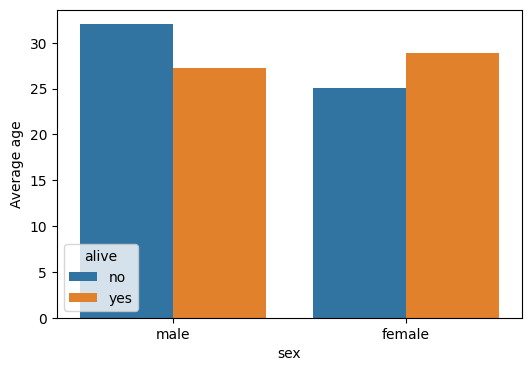

In [49]:
plt.figure(figsize=(6,4))
sns.barplot(x='sex',y='age',hue='alive',data=df,ci=False)
plt.ylabel('Average age')
plt.show()

`The average age of surviving males exceeds that of non-surviving males, while the average age of surviving females is lower than that of non-surviving females.`

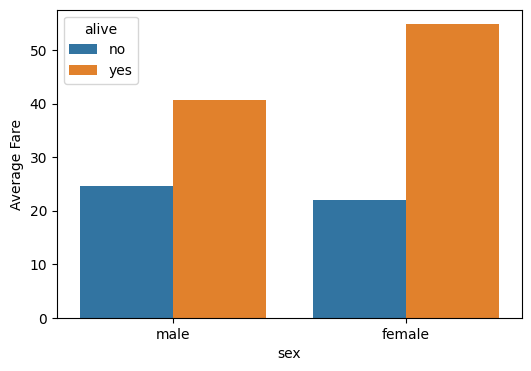

In [50]:
plt.figure(figsize=(6,4))
sns.barplot(x='sex',y='fare',hue='alive',data=df,ci=False)
plt.ylabel('Average Fare')
plt.show()

## 🔴Preprocessing

In [51]:
X = df.drop('alive',axis=1)
y = df.alive == 'yes'

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Handling outliers

In [53]:
X_train[nums].quantile([.01,.05,.1,.15,.2,.25,.75,.8,.85,.9,.95,.99,1])

,age,fare
0.01,0.948,0.00000
0.05,4.000,7.22500
0.10,10.500,7.55000
0.15,16.000,7.77500
0.20,18.000,7.85420
0.25,20.000,7.92500
0.75,38.000,30.92395
0.80,40.500,39.56000
0.85,45.000,53.10000
0.90,49.000,76.68545


In [54]:
X_train.loc[df['fare'] > 227.52500, 'fare'] = X_train['fare'].median()

### 🔴Handing the missing values, scaling and encoding

In [55]:
X_train.isna().mean() * 100

sex             0.000000
age            13.826367
sibsp           0.000000
parch           0.000000
fare            0.000000
class           0.000000
who             0.000000
adult_male      0.000000
embark_town     0.321543
alone           0.000000
dtype: float64

In [56]:
cats.pop()
cats

['sex', 'class', 'who', 'embark_town']

In [57]:
nums

['age', 'fare']

In [58]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, nums),
        ('cat', categorical_transformer, cats)],remainder='passthrough')

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## 🔴Resample then Train

In [59]:
from imblearn.over_sampling import SMOTE


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)


print("Class distribution after oversampling:")
print("Class 0:", sum(y_resampled == 0))
print("Class 1:", sum(y_resampled == 1))

Class distribution after oversampling:
Class 0: 365
Class 1: 365


## 🔴Model Selection && Cross Validation && Hyperparamters

In [60]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'CatBoost': CatBoostClassifier(verbose=False),
}

# hyperparameters for each model
params = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [100, 200, 300]},
    'Random Forest': {'n_estimators': [50, 100, 150]},
    'CatBoost':{},
    'SVC': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]}
}

# Perform model selection and evaluation
results = {}
for model_name, model in models.items():
    param_grid = {
        'classifier__' + param: values for param, values in params[model_name].items()
    }

    # Construct a pipeline with imputer, scaler, and classifier
    pipeline = Pipeline([
        ('classifier', model),
    ])

    # Perform hyperparameter tuning with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_resampled, y_resampled)

    # Store results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'Best Score': grid_search.best_score_
    }

    # Perform cross-validation to estimate performance
    cv_scores = cross_val_score(grid_search.best_estimator_, X_resampled, y_resampled, cv=5, scoring='f1')
    results[model_name]['CV Scores'] = cv_scores

# Print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Best Score (f1): {result['Best Score']}")
    print(f"Cross-Validation Scores (f1): {result['CV Scores']}")
    print(f"Average Cross-Validation Score (f1): {np.mean(result['CV Scores'])}\n")

# Select the best model based on average cross-validation score
best_model_name = max(results, key=lambda x: np.mean(results[x]['CV Scores']))
best_model = models[best_model_name]
print(best_model_name)
best_model.fit(X_resampled, y_resampled)
# Evaluate the best model on the testing data
y_pred = best_model.predict(X_test_preprocessed)
print(f"Classification Report for the Best Model:")
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model: Logistic Regression
Best Parameters: {'classifier__C': 10.0}
Best Score (f1): 0.7847610904535658
Cross-Validation Scores (f1): [0.77852349 0.76923077 0.76190476 0.79470199 0.81944444]
Average Cross-Validation Score (f1): 0.7847610904535658

Model: SVC
Best Parameters: {'classifier__C': 10.0, 'classifier__kernel': 'rbf'}
Best Score (f1): 0.7854066963386834
Cross-Validation Scores (f1): [0.7972973  0.73134328 0.76190476 0.8137931  0.82269504]
Average Cross-Validation Score (f1): 0.7854066963386834

Model: KNN
Best Parameters: {'classifier__n_neighbors': 3}
Best Score (f

In [61]:
confusion_matrix(y_test,y_pred)

array([[80, 11],
       [18, 47]])